# MODULES AND CONSTANTS

### MODULES, IMPORTS AND LIBRARIES

In [184]:
# GENERAL IMPORTS 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PLOTTING
import matplotlib.colors as colors
import matplotlib.cm as cmx

# PREPROCESSING
from sklearn.preprocessing import MinMaxScaler

# KMEANS
from sklearn.cluster import KMeans, BisectingKMeans, DBSCAN

# METRICS
from sklearn.metrics import silhouette_score, silhouette_samples


### CONSTANTS

In [185]:
INPUT_FILE = 'data.txt'

CLUSTERING_METHODS = [KMeans(n_clusters=14, random_state=42, tol=1e-8, max_iter=500, n_init=20),
                      BisectingKMeans(n_clusters=15, random_state=42, tol=1e-8, max_iter=500),
                      DBSCAN(eps=0.02, min_samples=3, n_jobs=-1)]

# DATASET LOAD

Load the synthetic 2-D dataset containing Gaussian clusters

In [186]:
def readData(path:str)->pd.DataFrame:
    """reads a data file given the path

    Args:
        path (str): the path to the data file

    Returns:
        data (pd.DataFrame): the data read (they are normalized in between 0 and 1)
    """
    df = pd.read_csv(filepath_or_buffer=path, header=0)
    return pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)

# DATA PLOTTING

Plot the data points as a scatter chart using the Matplotlib library. At first sight, you should see
15 different globular clusters. <br>Given this distribution, which could be the most suitable clustering
technique among the ones that you known? Why?

In [187]:
def plotPoints(df:pd.DataFrame)->None:
    """plots the points on a scatter plot

    Args:
        df (pd.DataFrame): the dataframe to be plotted
    """
    plt.figure(figsize=(10,10))
    plt.scatter(df['x'], df['y'])
    plt.show()

# KMEANS ALGORITHM

Runs the various Kmeans algorithm on the given dataset

In [188]:
def findClusters(df:pd.DataFrame, methods:list[KMeans]|KMeans=CLUSTERING_METHODS)->list[pd.DataFrame, dict]:
    """finds the possible clusters for the given data

    Args:
        df (pd.DataFrame): the dataFrame to be divided in clusters
        methods (list[KMeans] | KMeans, optional): The list of clusters algorithm to be used. Defaults to CLUSTERING_METHODS.

    Returns:
        df (list[pd.DataFrame, dict]): the augmented df with the clustering results and the dict of centroids when possible
    """
    methods:list[KMeans] = [methods] if not isinstance(methods, list) else methods
    centroids = {}
    
    for method in methods:
        name = method.__str__().split("(")[0]
        df[name] =  method.fit_predict(df[['x', 'y']])
        try:
            centroids[name] = method.cluster_centers_
        except AttributeError:
            pass
        
    return df, centroids

# PLOT RESULTS

Plots the results of the clustering for a given set of points

In [189]:
def plotClusteringResults(df:pd.DataFrame, centroids:dict)->None:
    """plots the clustering results per each clustering method

    Args:
        df (pd.DataFrame): the dataframe of measures
        centroids (dict): the centroids found (if the methods supports that)
    """
    columns:np = df.columns.difference(['x', 'y']).sort_values()
    
    fig, ax = plt.subplots(columns.shape[0], 1, figsize=(15, 15*columns.shape[0]))
    
    for i in range(columns.shape[0]):
        scalarMap = cmx.ScalarMappable(norm=colors.Normalize(vmin=df[columns[i]].min(), vmax=df[columns[i]].max()), 
                                    cmap=plt.get_cmap('tab20'))

        ax[i].scatter(x=df['x'], y=df['y'], c=scalarMap.to_rgba(df[columns[i]]))
        if columns[i] in centroids:
            ax[i].scatter(x=centroids[columns[i]][:, 0], y=centroids[columns[i]][:, 1], color=[0,0,0,1], marker='*')
            
        ax[i].set_title(f'Method {columns[i]}')


# SILHOUETTE SCORE

Evaluates the obtained silhouette score for each different cluster method.<br>

Implement a function to plot the silhouette values sorted in ascending order. This kind of chart is
particularly useful to inspect the overall performance of a clustering technique. <br>In an ideal case, the
curve is heavily shifted towards the value 1 on the y-axis, i.e. most of the points have been assigned
coherently. <br> Create the chart for both your datasets and discuss the results. <br> Do these plots match
the clustering performance that you expected looking at the scatter plots from the previous exercise,
point 5? 

In [190]:
def evaluateSilhouetteScore(df:pd.DataFrame)->None:
    columns:np = df.columns.difference(['x', 'y']).sort_values()
    
    fig, ax = plt.subplots(columns.shape[0], 1, figsize=(15, 15*columns.shape[0]))
    
    for i in range(columns.shape[0]):
        sil:np = silhouette_samples(df[['x', 'y']], df[columns[i]])
        ax[i].plot(list(range(sil.shape[0])), sorted(sil))
        ax[i].set_title(f'Method {columns[i]}')
        
    display(pd.DataFrame([silhouette_score(df[['x', 'y']], labels=df[col]) for col in columns], columns=['value'], index=columns).T)

# VARYING SILHOUETTE BY K MEANS

Define a function that, given a set of K values and a dataset, plots a line chart with the values of the
average silhouette obtained for each K. By simply looking at it, you should be able to identify the
best K for the task. <br>Is it the one that you expected beforehand? Can you spot a trend (e.g. the higher
the K value the higher the average silhouette)? Discuss this especially for the Chameleon dataset.


In [191]:
def testSilhouetteScoreByKMeans(df:pd.DataFrame, start:int=2, stop:int=30) -> None:
    start = max(start, 2)

    fig, ax = plt.subplots(1,1,figsize=(20,10))

    ax.plot(
        list(range(start, stop)),
        [ silhouette_score(df[['x', 'y']], labels=KMeans(n_clusters=i, random_state=42, tol=1e-8, max_iter=500).fit_predict(df[['x', 'y']]))
            for i in range(start, stop)],
        '-*'
        )
    ax.grid(True)
    ax.set_xticks(list(range(start-1, stop+1)))
    ax.set_ylim(0, 1)
    ax.set_title('Avg silhouette score by number of cluster value')
    ax.set_xlabel("number of clusters")
    ax.set_ylabel("silhouette score value")
    plt.show()

# MAIN FUNCTION

This is the main function of the program, it does:
<ol>
<li>Loads the dataset as a dataframe</li>
<li>Plots the found points on the graph</li>
<li>Performs KMeans algorithm on the Data</li>
<li>Plots the clusters found</li>
<li>Evaluates the obtained silhouette score</li>
<li>Evaluates the various average silhouette score obtained for k varying </li>
</ol>

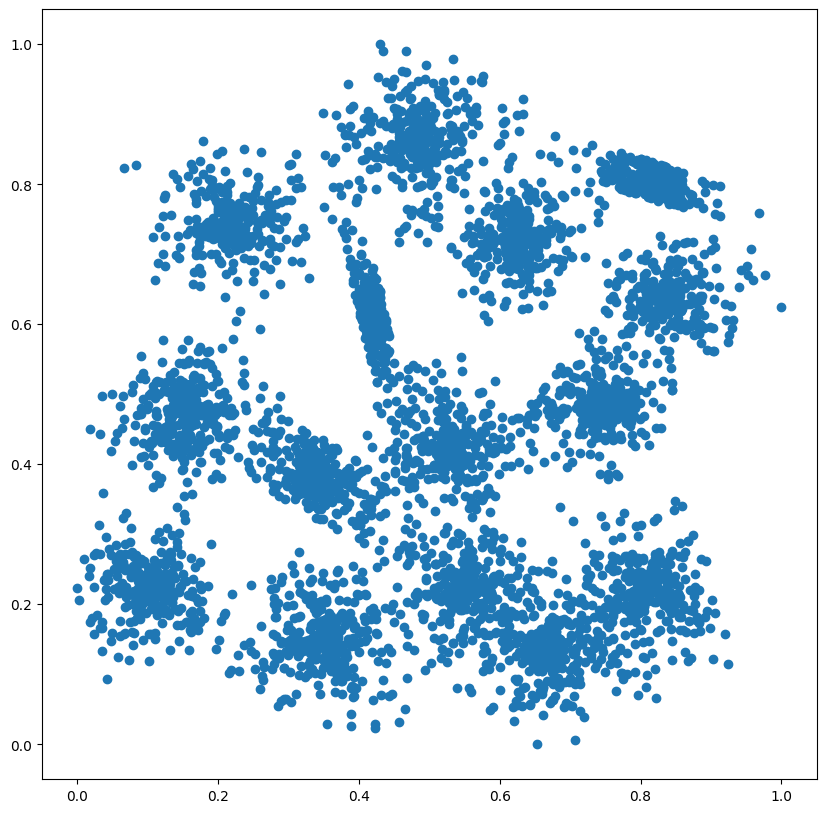

,BisectingKMeans,DBSCAN,KMeans
value,0.564545,-0.229774,0.612139


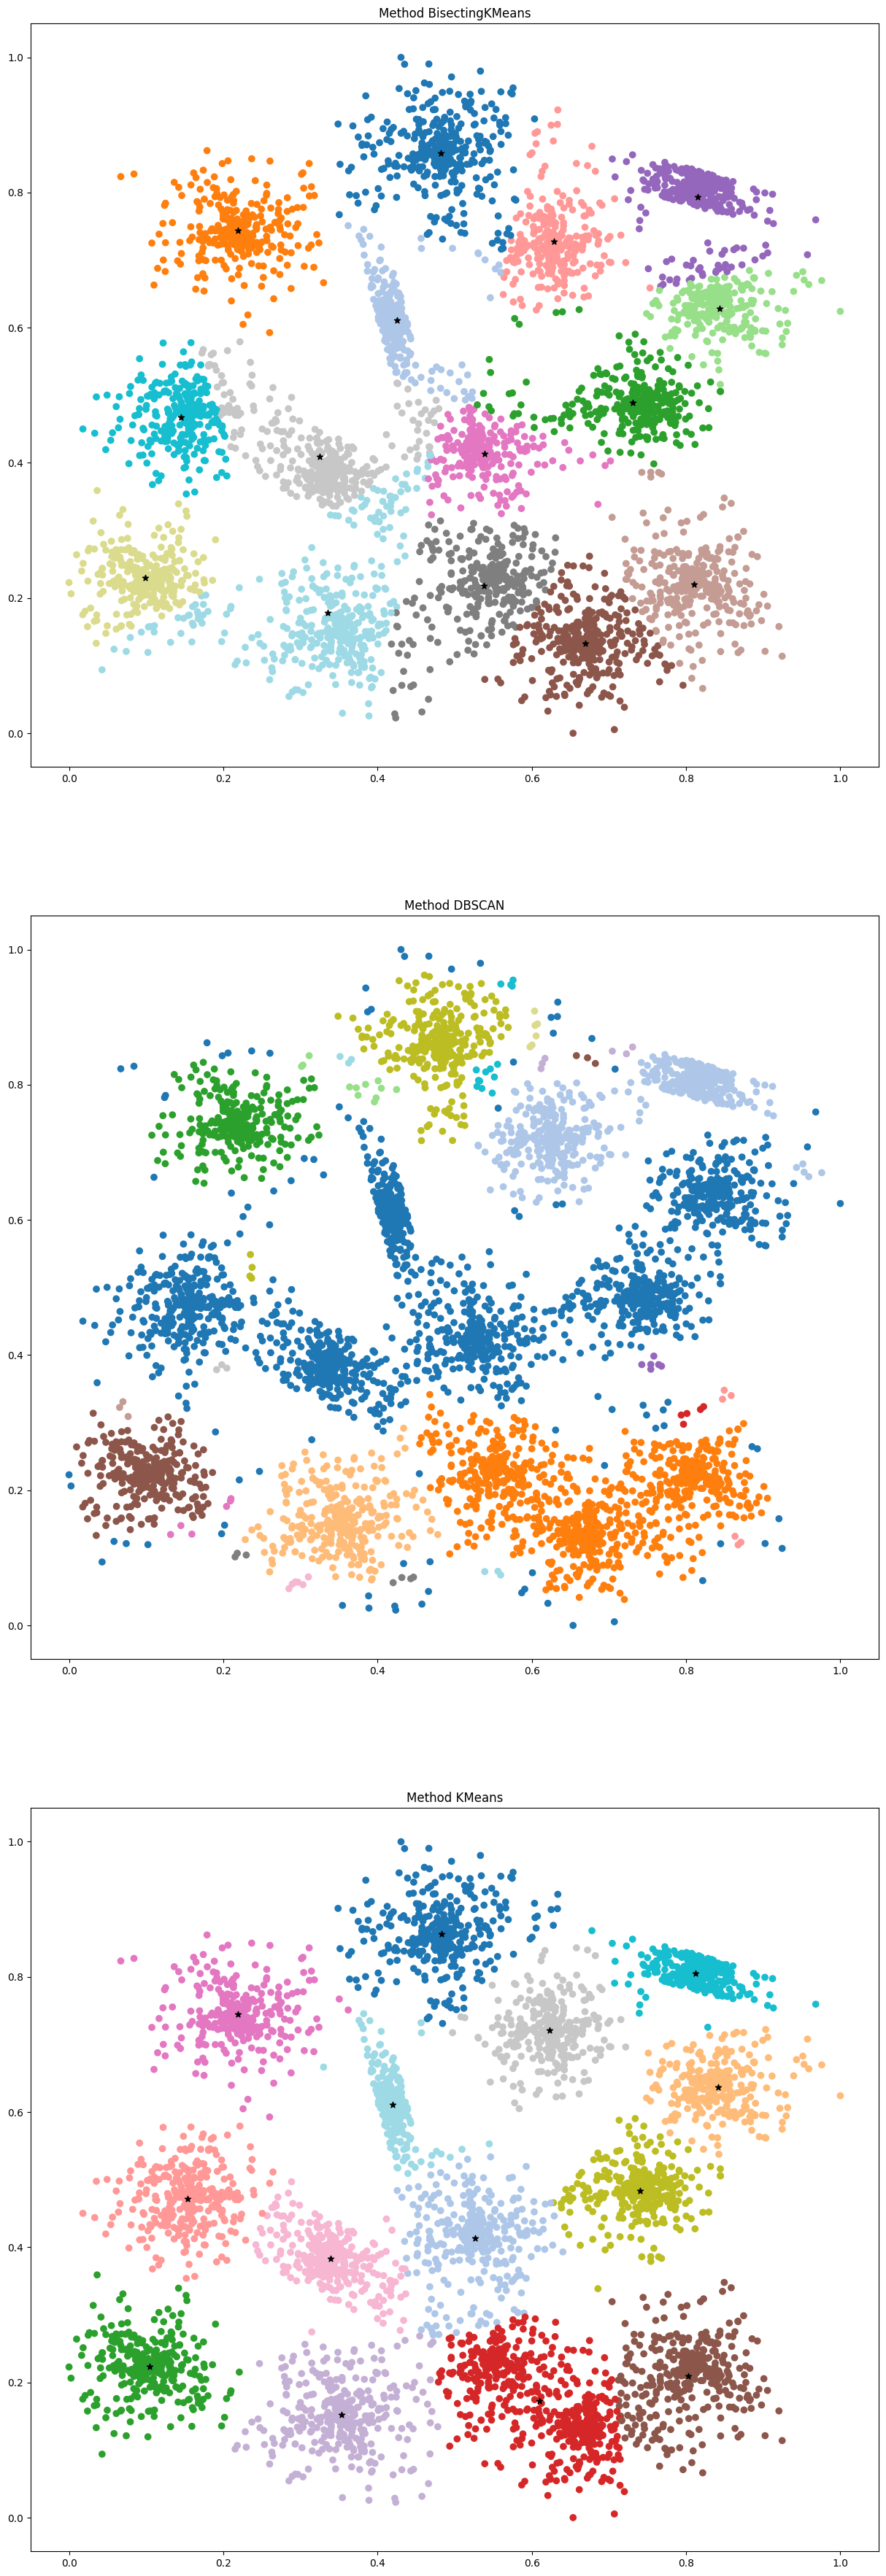

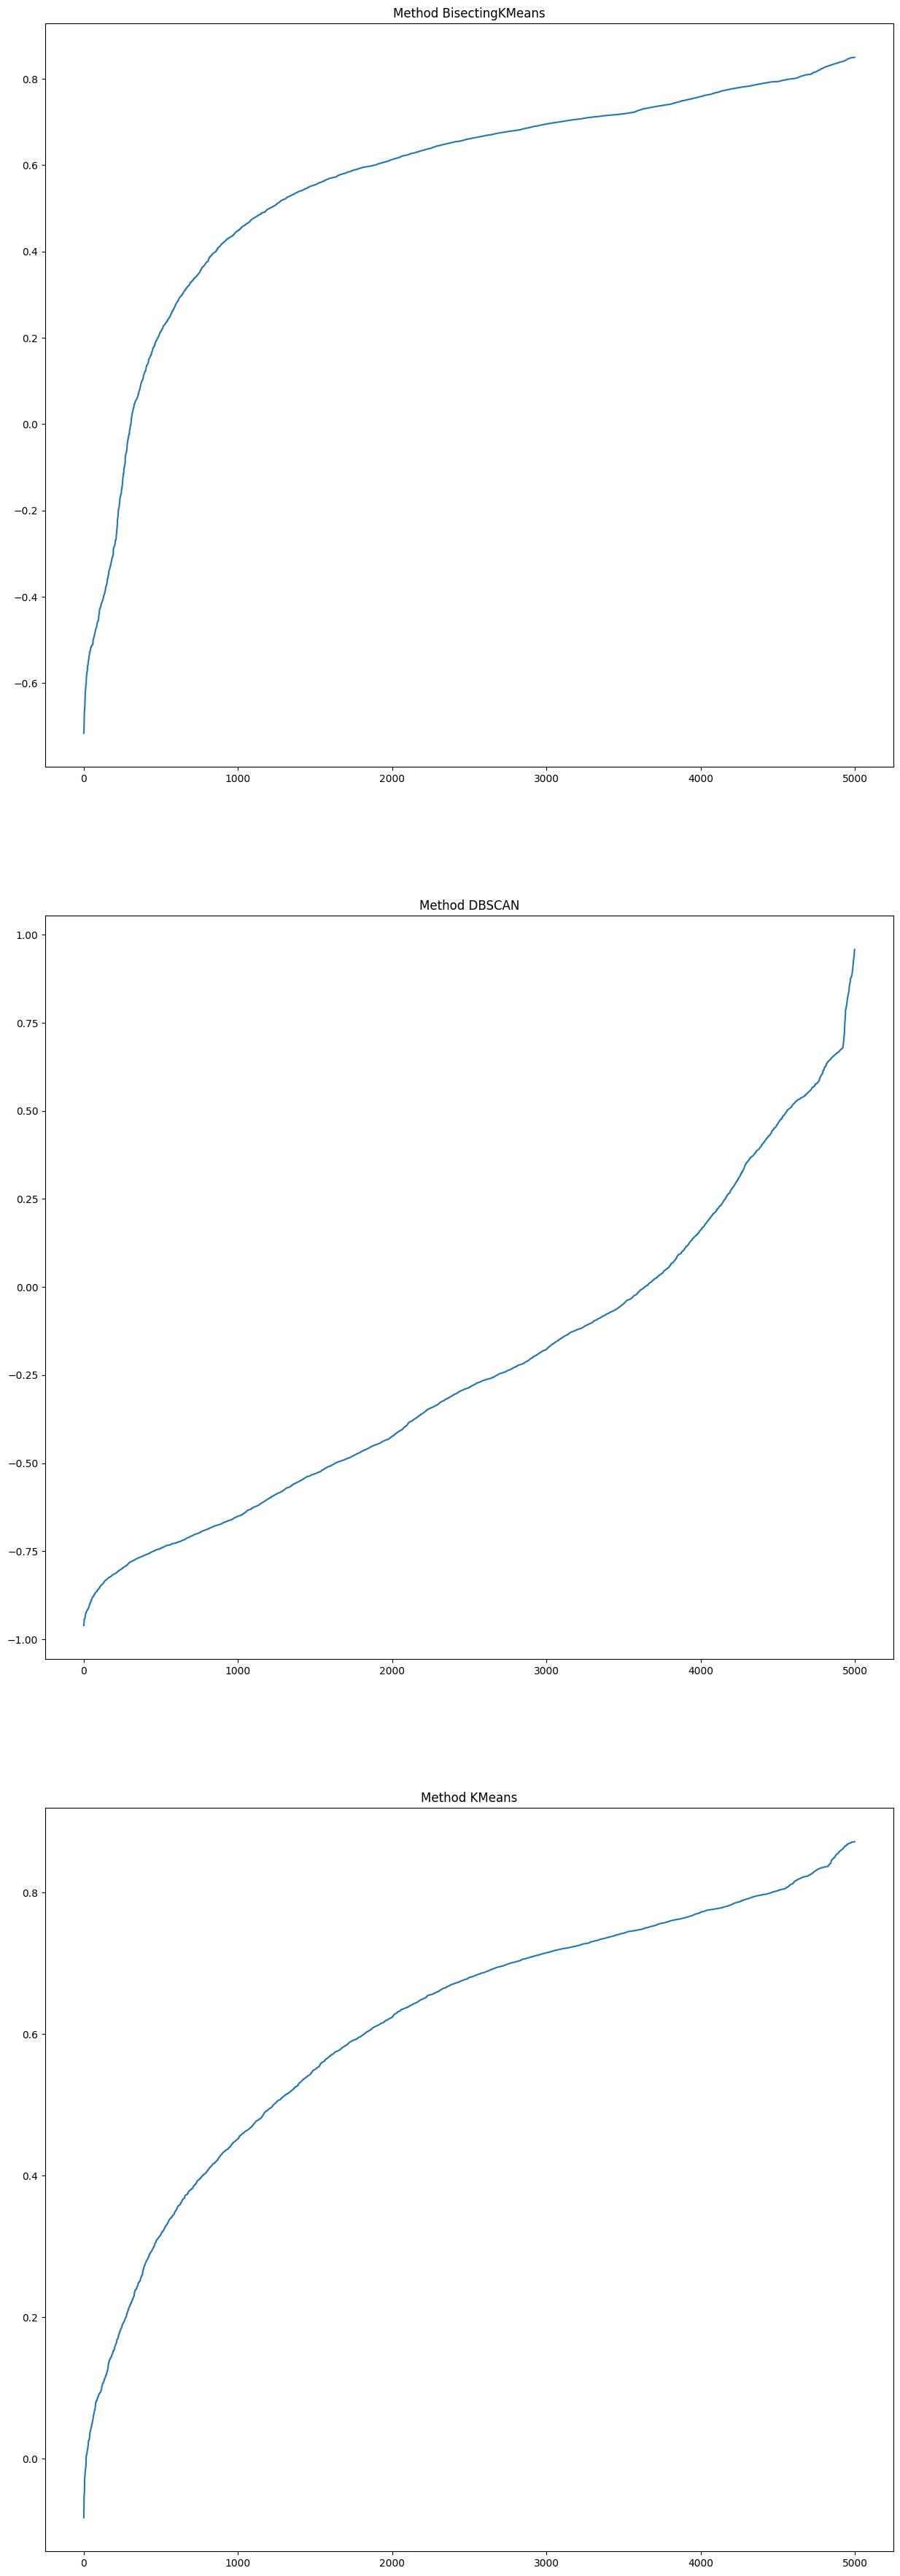

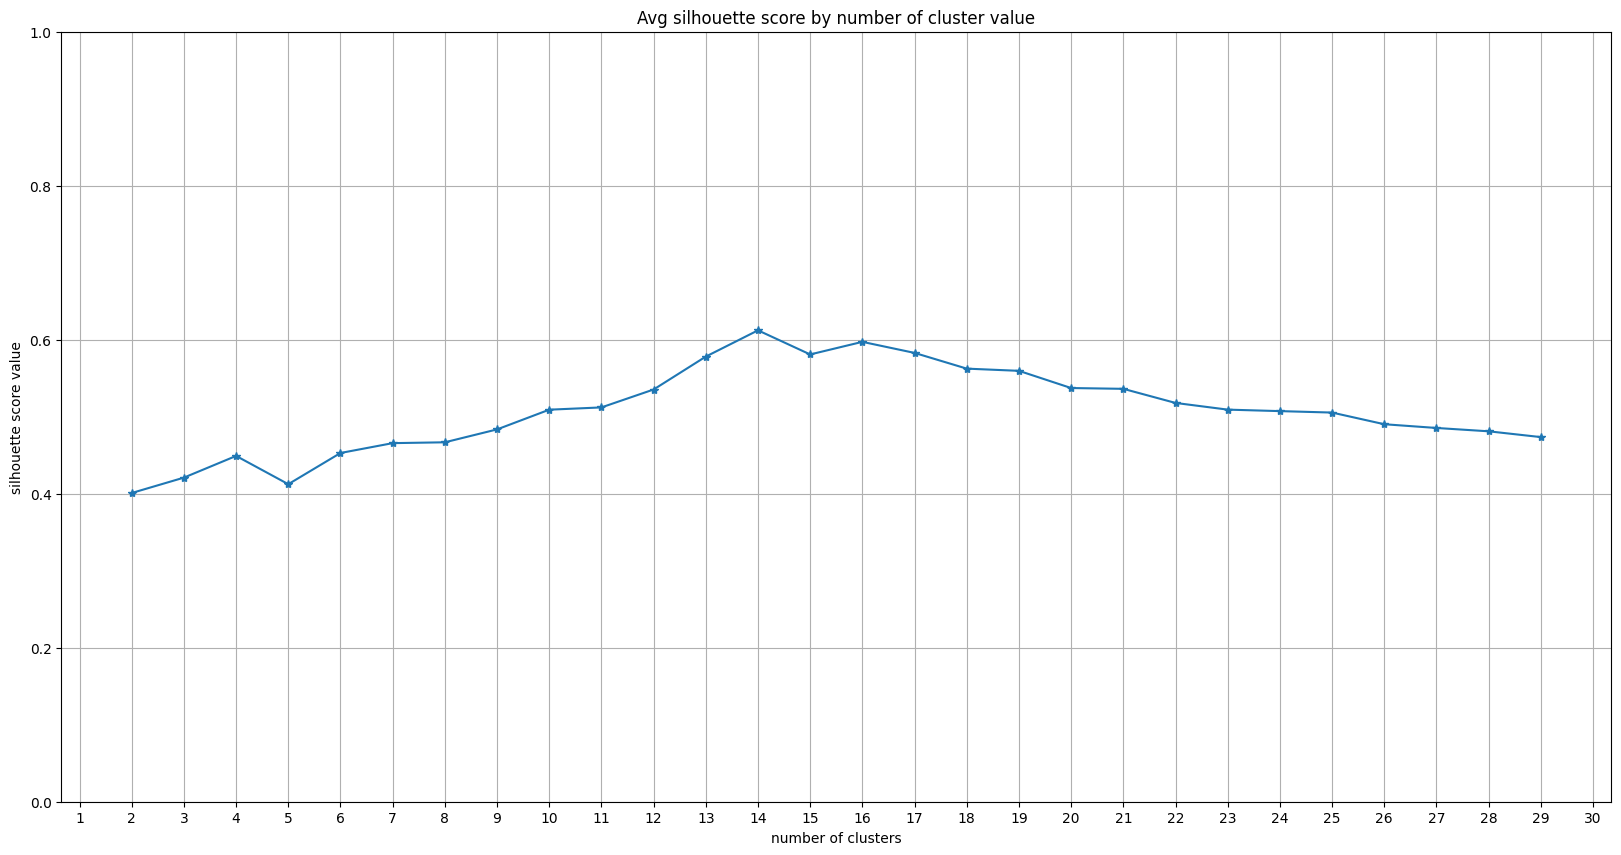

In [192]:
def main()->None:
    df = readData(INPUT_FILE) # 1
    plotPoints(df) # 2
    df, centroids = findClusters(df, CLUSTERING_METHODS) # 3
    plotClusteringResults(df, centroids) # 4
    evaluateSilhouetteScore(df) # 5
    testSilhouetteScoreByKMeans(df, start=2, stop=30) # 6
    
    
main()